# env: swabian

In [1]:
import os

In [2]:
import TimeTagger as TT
from TimeTagger import Flim, TimeTagStream, createTimeTaggerVirtual, EventGenerator, Countrate,ConstantFractionDiscriminator, DelayedChannel
#from intensity_renderer import IntensityRenderer
import numpy as np
from matplotlib.pyplot import *
from scipy.ndimage import maximum_filter

In [3]:
dump_file = r"C:\Users\lociu\Desktop\PriyaM\Data\20230703_swab_tests\TimeTags_2023-07-03_125136.ttbin"

# flim

In [4]:
laser = 1
click = laser
frame = 3 
frame_n = -3
line = 2
line_n = -2
photon = -4

n_bins = 256
binwidth = 49 # 12.5ns/256
n_pixel = 256

laser_frequency = 80e6  # 1/12.5ns

pixel_rate = 200e3
pixel_time = 1 / pixel_rate
integr_time = 3e9 # Integration time of 3 ms in picoseconds

In [5]:
time_tag_virt=TT.createTimeTaggerVirtual()

In [6]:
pixel_pattern_start = np.linspace(0, 256, num=n_pixel, endpoint=False, dtype=int) * (pixel_time * 1e12)

In [7]:
pixel_pattern_end = pixel_pattern_start + integr_time

# check pixel channels

In [326]:
# EventGenerator(tagger, trigger_channel, pattern, trigger_divider, stop_channel)
pixel_start_channel = EventGenerator(time_tag_virt, line, pixel_pattern_start)
pixel_end_channel= EventGenerator(time_tag_virt, line, pixel_pattern_end)

In [327]:
pixel_start = pixel_start_channel.getChannel()
pixel_end = pixel_end_channel.getChannel()

In [328]:
# Countrate(tagger, channels)
rate = Countrate(time_tag_virt, [frame, line, pixel_start])

In [329]:
all_rates = Countrate(time_tag_virt, [1, 2, 3, 4, -1, -2, -3, -4])

In [330]:
intervals = TT.StartStop(time_tag_virt, -line, line, 0.1e-3/1e-12)

In [331]:
%%time
time_tag_virt.setReplaySpeed(-1)
replay = time_tag_virt.replay(dump_file)
time_tag_virt.waitForCompletion()

CPU times: total: 391 ms
Wall time: 507 ms


True

In [332]:
#check that pixel clock is correct
# Run Countrate for 1 second and print the result for all three channels
#rate.startFor(int(1e12), clear=True)
#rate.waitUntilFinished()
comp_data = rate.getData()
comp_data

array([1.23333333e+00, 3.21366667e+02, 8.22676333e+04])

In [333]:
print("lines/frame = ", comp_data[1]/comp_data[0])
print("pixels/line = ", comp_data[2]/comp_data[1])

lines/frame =  260.56756756756755
pixels/line =  255.9930505134322


In [334]:
all_rates.getData()

array([1.37906200e+05, 3.21366667e+02, 1.23333333e+00, 1.38022100e+05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38028933e+05])

In [335]:
fi = intervals.getData()
fi

array([], shape=(0, 2), dtype=int64)

# flim class

In [27]:
time_tag_virt=TT.createTimeTaggerVirtual()
time_tag_virt.reset()

In [28]:
# EventGenerator(tagger, trigger_channel, pattern, trigger_divider, stop_channel)
pixel_start_channel = EventGenerator(time_tag_virt, line, pixel_pattern_start)
pixel_start = pixel_start_channel.getChannel()

pixel_end_channel= EventGenerator(time_tag_virt, line, pixel_pattern_end)
pixel_end = pixel_end_channel.getChannel()

In [29]:
#ConstantFractionDiscriminator(tagger, channels, search_window)
photon_cfd_chan = ConstantFractionDiscriminator(time_tag_virt, (photon,), 10*1000)
photon_cfd = photon_cfd_chan.getChannels()[0]

In [30]:
#DelayedChannel(tagger, input_channel, delay)
delayed_sync_chan = DelayedChannel(time_tag_virt, laser, 11.5e3)
delayed_sync = delayed_sync_chan.getChannel()

In [31]:
flim = Flim(time_tag_virt, start_channel=delayed_sync, click_channel=photon_cfd, pixel_begin_channel=pixel_start, n_pixels=n_pixel*n_pixel,
             n_bins=n_bins, binwidth=binwidth, pixel_end_channel=pixel_end, frame_begin_channel=frame)

In [32]:
%%time
time_tag_virt.setReplaySpeed(-1)
replay = time_tag_virt.replay(dump_file)
time_tag_virt.waitForCompletion()

CPU times: total: 1.3 s
Wall time: 1.26 s


True

In [33]:
#flim.waitUntilFinished()
flim.getFramesAcquired()

36

In [34]:
flim_frames = flim.getSummedFrames()

In [35]:
flim_frames.shape

(65536, 256)

In [36]:
flim_2d = flim_frames.reshape(256,256,256)

In [37]:
flim_mean = flim_2d.mean(2)
flim_mean.shape

(256, 256)

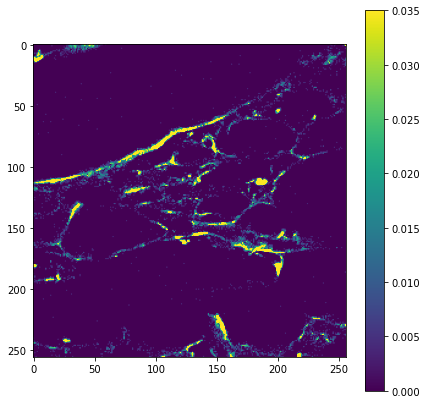

In [38]:
#rcParams['figure.figsize'] = [10,10]
figure(figsize=[7,7])
imshow(flim_mean,vmax=.035)
colorbar()

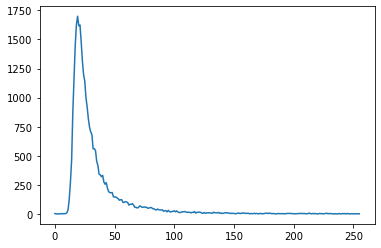

In [39]:
plot(flim_2d.sum((0,1)))

In [40]:
maximas = (flim_mean == maximum_filter(flim_mean, footprint=np.ones((50,50))))

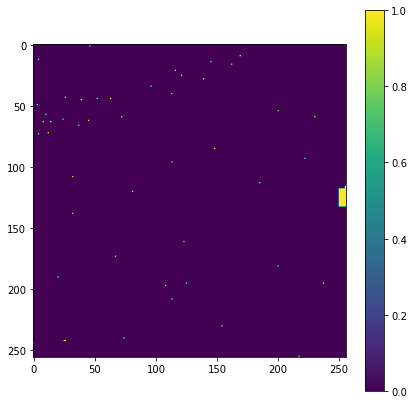

In [26]:
figure(figsize=[7,7])
imshow(maximas)
colorbar()

In [20]:
#check how many for percent
dec = .005
perc = 100- (dec*100)
flim_mean.size *dec

327.68

In [21]:
maxima2 = (flim_mean==np.percentile(flim_mean.ravel(), perc))

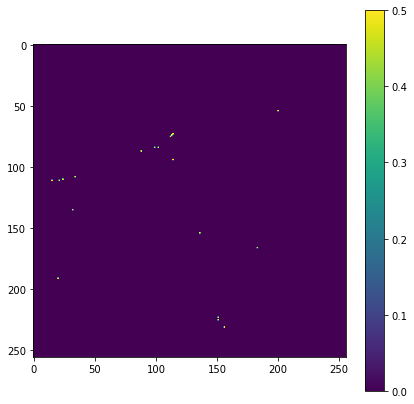

In [22]:
figure(figsize=[7,7])
imshow(maxima2,vmax=.5)
colorbar()

# intensity renderer class

#with the parameter 'divider', you can select how many input frames are integrated over to get one output frame
intensity = IntensityRenderer(time_tag_virt, start_channel=photon, click_channel=laser, pixel_begin_channel=pixel, pixels_x=256, pixels_y=256,
                              n_bins=bins, binwidth=binwidth, pixel_end_channel=pixelEnd, frame_begin_channel=frame, num_frames=0, divider=4, is_resonant=True)

# swab ex

In [34]:
# The format for the table and the head of the table
format_string = '{:>8} | {:>17} | {:>7} | {:>14} | {:>13}'
#print(format_string.format('TAG #', 'EVENT TYPE', 'CHANNEL', 'TIMESTAMP (ps)', 'MISSED EVENTS'))
#print('---------+-------------------+---------+----------------+--------------')

In [35]:
%%time

n_events = 100000  # Number of events to read at once
event_name = ['0 (TimeTag)', '1 (Error)', '2 (OverflowBegin)', '3 (OverflowEnd)', '4 (MissedEvents)']
i = 0

t_events =0
while fr.hasData():
    # getData() does not return timestamps, but an instance of TimeTagStreamBuffer
    # that contains more information than just the timestamp
    data = fr.getData(n_events=n_events)

    # With the following methods, we can retrieve a numpy array for the particular information:
    channel = data.getChannels()            # The channel numbers
    timestamps = data.getTimestamps()       # The timestamps in ps
    overflow_types = data.getEventTypes()   # TimeTag = 0, Error = 1, OverflowBegin = 2, OverflowEnd = 3, MissedEvents = 4
    missed_events = data.getMissedEvents()  # The numbers of missed events in case of overflow

    # Output to table
    if i < 2 or not fr.hasData():
        print(format_string.format(*" "*5))
        heading = ' Start of data chunk {} with {} events '.format(i+1, data.size)
        extra_width = 69 - len(heading)
        print('{} {} {}'.format("="*(extra_width//2), heading, "="*(extra_width - extra_width//2)))
        print(format_string.format(*" "*5))
        print(format_string.format(i*n_events + 1, event_name[overflow_types[0]], channel[0], timestamps[0], missed_events[0]))
        if data.size > 1:
            print(format_string.format(i*n_events + 2, event_name[overflow_types[1]], channel[1], timestamps[1], missed_events[1]))
        if data.size > 3:
            print(format_string.format(*["..."]*5))
        if data.size > 2:
            print(format_string.format(i*n_events + data.size, event_name[overflow_types[-1]], channel[-1], timestamps[-1], missed_events[-1]))
    if i == 1:
        print(format_string.format(*" "*5))
        for j in range(3):
            print(format_string.format(*"."*5))
    i += 1
    
    t_events = t_events + len(channel)
    

#show that it's done
print("done")


         |                   |         |                |              
=============  Start of data chunk 1 with 100000 events  ==============
         |                   |         |                |              
       1 |       0 (TimeTag) |       1 | 279827555654787 |             0
       2 |       0 (TimeTag) |      -1 | 279827555661643 |             0
     ... |               ... |     ... |            ... |           ...
  100000 |       0 (TimeTag) |       1 | 279828179922494 |             0
         |                   |         |                |              
=============  Start of data chunk 2 with 100000 events  ==============
         |                   |         |                |              
  100001 |       0 (TimeTag) |      -1 | 279828179929321 |             0
  100002 |       0 (TimeTag) |       1 | 279828179934930 |             0
     ... |               ... |     ... |            ... |           ...
  200000 |       0 (TimeTag) |       1 | 279828804139874 | 

#### length of events : 1854399131 

In [36]:
fr.getData(1).getChannels()

array([], dtype=int32)

# my exp:

In [37]:
## pretty print for json
fr.getConfiguration()

{'channel number scheme': 2,
 'configure version': 1,
 'current time': '2022-06-10 16:33:51 -0500',
 'devices': [{'PCB version': '1.6b (1)',
   'model': 'Time Tagger Ultra',
   'serial': '2143000XZI'}],
 'firmware version': 'TT-Ultra, FW 5, TS 2022-02-02 13:09:16, OK 1.31',
 'hardware buffer size': 67108864,
 'inputs': [{'channel': [1, -1],
   'conditional filter filtered': [False, False],
   'conditional filter triggers': [False, False],
   'deadtime': [2000, 2000],
   'delay hardware': [0, 0],
   'delay software': [0, 0],
   'event divider': [0, 0],
   'hardware delay compensation': [552, 552],
   'input mux': 0,
   'normalization': [True, True],
   'resolution': 'Standard',
   'resolution rms': 9.0,
   'trigger level': -0.050011444266422345},
  {'channel': [2, -2],
   'conditional filter filtered': [False, False],
   'conditional filter triggers': [False, False],
   'deadtime': [2000, 2000],
   'delay hardware': [0, 0],
   'delay software': [0, 0],
   'event divider': [0, 0],
   'ha

In [ ]:
buf = fr.getData(0)
print(buf.tStart, buf.getTimestamps(), buf.getChannels())

#### last byte on the stream : 329628425460000 


In [235]:
fr = TT.FileReader(r"C:\Users\lociu\Desktop\PriyaM\Data\Swabian_tests\test.ttbin")

In [236]:
fr.getChannelList()

(1, 2, 3, 4, -1, -2, -3, -4)

In [237]:
buf = fr.getData(0)
print(buf.tStart, buf.getTimestamps(), buf.getChannels())

-1 [] []


In [238]:
total_events

NameError: name 'total_events' is not defined

In [239]:
n_events = int(1854399131.0)

while fr.hasData():
    data = fr.getData(n_events=n_events)

# With the following methods, we can retrieve a numpy array for the particular information:
channel = data.getChannels()            # The channel numbers
timestamps = data.getTimestamps()       # The timestamps in ps
event_types = data.getEventTypes()   # TimeTag = 0, Error = 1, OverflowBegin = 2, OverflowEnd = 3, MissedEvents = 4
missed_events = data.getMissedEvents()  # The numbers of missed events in case of overflow

In [240]:
type(data)

TimeTagger.TimeTagStreamBuffer

In [242]:
len(channel), len(event_types)

(1854399131, 1854399131)

In [243]:
import numpy as np

In [244]:
%%time
len(np.where(channel==1))

CPU times: total: 11.1 s
Wall time: 11.2 s


1

In [245]:
%%time
for ch in range(-4,5):
    ch_1 = np.where(np.logical_and(channel==ch, event_types == 0))
    print(ch, ch_1[0].shape)
    

-4 (2377917,)
-3 (10,)
-2 (4821,)
-1 (924769909,)
0 (0,)
1 (924769906,)
2 (4812,)
3 (20,)
4 (2377130,)
CPU times: total: 29.9 s
Wall time: 29.9 s


In [249]:
%%time
for ch in range(-4,5):
    ch_1 = np.where(np.logical_and(channel==ch, event_types == 4))
    print(ch, ch_1[0].shape)
    

-4 (271,)
-3 (42,)
-2 (42,)
-1 (46906,)
0 (0,)
1 (46906,)
2 (42,)
3 (42,)
4 (271,)
CPU times: total: 23.7 s
Wall time: 23.8 s


In [2]:
46906/924769909

5.0721806087658934e-05

In [ ]:
1:laser/sync
2: line clock
3: frame clock
4: photons

In [23]:
def tests(n,m):
    print("\nSize:")
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.size)
    
    print("\nChannels:")
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.getChannels())
        
    print("\nEvent Types:")    
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.getEventTypes())
        
    print("\nTime Stamps:")
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.getTimestamps())
        
    print("\nGet Data:")
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.tGetData)
        
    print("\nT Start:")
    for i in range(n,m):
        x = fr.getData(i)
        print(i,":", x.tStart)

In [24]:
tests(1,10)


Size:
1 : 0
2 : 0
3 : 0
4 : 0
5 : 0
6 : 0
7 : 0
8 : 0
9 : 0

Channels:
1 : []
2 : []
3 : []
4 : []
5 : []
6 : []
7 : []
8 : []
9 : []

Event Types:
1 : []
2 : []
3 : []
4 : []
5 : []
6 : []
7 : []
8 : []
9 : []

Time Stamps:
1 : []
2 : []
3 : []
4 : []
5 : []
6 : []
7 : []
8 : []
9 : []

Get Data:
1 : 329628425460000
2 : 329628425460000
3 : 329628425460000
4 : 329628425460000
5 : 329628425460000
6 : 329628425460000
7 : 329628425460000
8 : 329628425460000
9 : 329628425460000

T Start:
1 : 329628425460000
2 : 329628425460000
3 : 329628425460000
4 : 329628425460000
5 : 329628425460000
6 : 329628425460000
7 : 329628425460000
8 : 329628425460000
9 : 329628425460000


# server and client?